# Sarsa

1.   Model-free
2. TD-control

## Algorithm

![sarsa](https://cdn-images-1.medium.com/max/800/1*Wim9wr-jYJtZyZ_4ZJRHNg.jpeg)

## Sarsa vs. Q-Learning

### Update steps:

Q Learning:
* Q(st,at)←Q(st,at)+α[rt+1+γmaxa′Q(st+1,a′)−Q(st,at)]

SARSA:
* Q(st,at)←Q(st,at)+α[rt+1+γQ(st+1,at+1)−Q(st,at)]

### Q-learning has the following advantages and disadvantages compared to SARSA:

* Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. If you want to learn an optimal policy using SARSA, then you will need to decide on a strategy to decay ϵ in ϵ-greedy action choice, which may become a fiddly hyperparameter to tune.

* Q-learning (and off-policy learning in general) has higher per-sample variance than SARSA, and may suffer from problems converging as a result. This turns up as a problem when training neural networks via Q-learning.

* SARSA will approach convergence allowing for possible penalties from exploratory moves, whilst Q-learning will ignore them. That makes SARSA more conservative - if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. The classic toy problem that demonstrates this effect is called cliff walking.

## References:

*   Ch 12.1:Model Free Reinforcement learning algorithms (Monte Carlo, SARSA, Q-learning), Madhu Sanjeevi ( Mady )
  * https://medium.com/deep-math-machine-learning-ai/ch-12-1-model-free-reinforcement-learning-algorithms-monte-carlo-sarsa-q-learning-65267cb8d1b4
*   dennybritz/reinforcement-learning/TD/SARSA Solution.ipynb
  * https://github.com/dennybritz/reinforcement-learning/blob/master/TD/SARSA%20Solution.ipynb
* Neil Slater, When to choose SARSA vs. Q Learning
  * https://stats.stackexchange.com/questions/326788/when-to-choose-sarsa-vs-q-learning


In [1]:
from IPython.display import clear_output
import gym
env = gym.make('Taxi-v2')
env.reset()
for _ in range(3):
  env.render()
  env.step(env.action_space.sample()) # take a random action

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [0]:
#@title Import EpisodeStats, plot_episode_stats
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [0]:
import random
def explore(epsilon=0.1):
  """
  Return True if explore, False if exploit.
  """
  num = random.uniform(0, 1)
  
  # Exploit
  if num > epsilon:
    return False
  # Explore
  else:
    return True
  
def greedy(state):
  """
  Return the action with highest Q value.
  """
  A = np.argmax(Q[state])
  return A

def epsilon_greedy(Q, state):
  A = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
  best_action = np.argmax(Q[state])
  A[best_action] += 1.0 - epsilon
  
  return A

def select_action(prob_dist):
  return np.random.choice(np.arange(env.action_space.n), p=prob_dist)

In [0]:
from collections import defaultdict
import itertools

episodes = 1000
epsilon = 0.1
gamma = 1.0 # Discount factor
alpha = 0.5

#Q = defaultdict(lambda: np.random.rand(env.action_space.n)) # Random initialisation
Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Zero initialisation

# For graphing
stats = EpisodeStats(
    episode_lengths=np.zeros(episodes),
    episode_rewards=np.zeros(episodes))

for i in range(episodes):
  current_state = env.reset()
  
  # Explore/exploit based on epsilon-greedy policy
  prob_dist = epsilon_greedy(Q, current_state)
  current_action = select_action(prob_dist)
  
  """
  Note: The following is a common implementation mistake that causes lower performance
        as env.action_space.sample() may take the greedy() action by chance. The
        greedy action needs to be excluded if we were to choose Explore instead of Exploit.
        
  # Explore if > epsilon else Exploit
  if explore(epsilon) is True:
    current_action = env.action_space.sample()
  else:
    current_action = greedy(current_state)
  """
  
  for t in itertools.count():
    # Take action step
    next_state, reward, done, _ = env.step(current_action)
    
    # Explore/exploit
    prob_dist = epsilon_greedy(Q, next_state)
    next_action = select_action(prob_dist)

    # Q update
    targetQ = reward + gamma * Q[next_state][next_action] # Note: Q(t+1) is derived from the epsilon-greedy action.
    currentQ = Q[current_state][current_action]
    Q[current_state][current_action] = Q[current_state][current_action] + alpha * (targetQ - currentQ)
    
    
    # Update T+1 action and states
    current_action = next_action
    current_state = next_state
    
    # For graphing
    stats.episode_rewards[i] += reward
    stats.episode_lengths[i] = t
    
    # Only stop when done.
    if done:
      break    

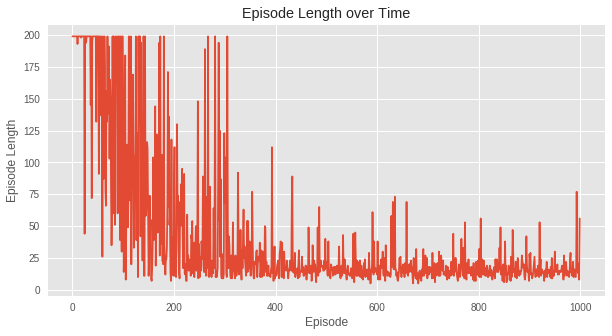

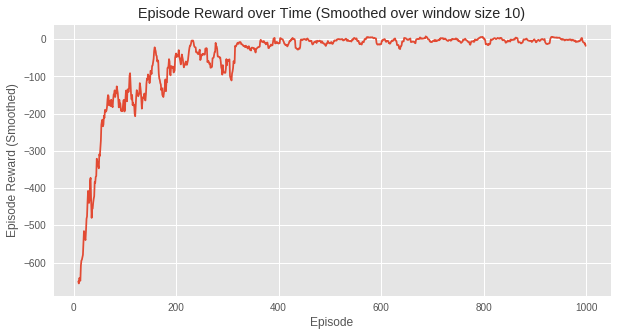

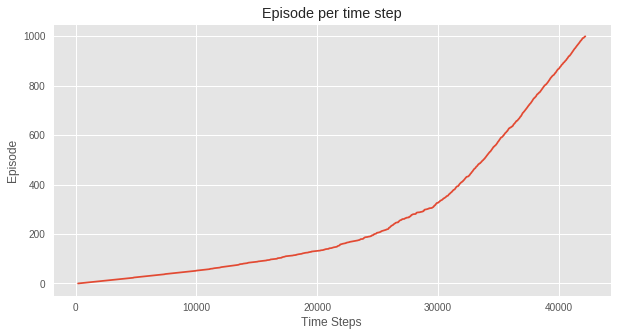

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
plot_episode_stats(stats)